In [ ]:
import numpy as np
from pandas import DataFrame
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def sigmoid_derivat(dA, x):
  """
  sigmoid'(x) = x' * sigmoid(x) * (1 - sigmoid(x))
  """
  f = sigmoid(x)

  return dA * f * (1- f)

def relu_derivat(dA, x):
  """ relu'(x) = [0 daca x <=0 altfel 1] * x' """
  dX = np.array(dA, copy=True)
  dX[x <= 0] = 0
  return dX


In [ ]:
def bce(y, y_hat):
  n = y.shape[1]
  loss = (-1/n)*(np.dot(y, np.log(y_hat).T) + np.dot(1 - y, np.log(1-y_hat).T))

  return np.squeeze(loss)

In [ ]:
def accuracy_score(y, y_hat):
  classes = (y_hat >= 0.5).astype(int)

  return (classes == y).mean()

In [ ]:
## dA_curr: Gradient of the loss with respect to the current layer's activation
## W_curr: Current layer's weights
## b_curr: Current layer's biases
## Z_curr: Linear combination of inputs (Z = W * A_prev + b)
## A_prev: Activations of the previous layer

class NN():
    """
    Varianta definire NN cu specificare input si output pentru fiecare unitate. Varianta vectorizata. Implementarile vectorizate consuma mai putine resurse computationale decat cele iterative
    """
    def __init__(self, architecture, random_seed=42):
        np.random.seed(random_seed)

        self.activation_functions = {
            'sigmoid': sigmoid,
            'relu': relu
        }

        self.derivatives = {
            'relu': relu_derivat,
            'sigmoid': sigmoid_derivat
        }


        number_of_layers = len(architecture)
        params_values = {}

        for idx, layer in enumerate(architecture):
            layer_idx = idx + 1

            layer_input_size = layer["input_dim"]

            layer_output_size = layer["units"]

            params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1

            params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1


        self.params = params_values
        self.architecture = architecture

    def summary(self):
        print("{:^15s} {:^15s} {:^15s} {:^15s} {:^15s} {:^15s} \n".format(
            "Input shape",
            "Output shape",
            "Weights shape",
            "Bias shape",
            "Activation",
            "Params"
        ))
        print("{:_<100s}".format(''))
        total_params = 0
        for idx, layer in enumerate(self.architecture):
            layer_idx = idx + 1
            in_shape = layer["input_dim"]
            out_shape = layer["units"]

            weights_shape = self.params['W' + str(layer_idx)].shape
            bias_shape = self.params['b' + str(layer_idx)].shape

            activation = layer["activation"]

            weights_params = 1
            for dim in weights_shape:
                weights_params *= dim

            bias_params = 1
            for dim in bias_shape:
                bias_params *= dim

            num_params = bias_params + weights_params
            total_params += num_params

            print("{:^15d} {:^15d} {:^15s} {:^15s} {:^15s} {:^15d} \n".format(
                in_shape,
                out_shape,
                str(weights_shape),
                str(bias_shape),
                activation,
                num_params
            ))
            print("-"*100)

        print("Total number of parameters: {}".format(total_params))

    def forward(self, w, b, x, activation='relu'):
        z = np.dot(w, x) + b

        return self.activation_functions[activation](z), z

    def predict(self, x):
        """ Functie cu care realizam predictii prin metoda propagarii inainte. """
        memory = {}
        current_activation = x

        for idx, layer in enumerate(self.architecture):
            layer_idx = idx + 1
            previous_activation = current_activation

            activation_function = layer["activation"]

            w = self.params["W" + str(layer_idx)]

            b = self.params["b" + str(layer_idx)]

            current_activation, z = self.forward(w, b, previous_activation, activation_function)

            memory["x" + str(idx)] = previous_activation
            memory["z" + str(layer_idx)] = z

        return current_activation, memory

    def backward(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
        # number of examples
        m = A_prev.shape[1]

        # selection of activation function
        backward_activation_func = self.derivatives[activation]

        # calculation of the activation function derivative
        dZ_curr = backward_activation_func(dA_curr, Z_curr)

        # derivative of the matrix W
        dW_curr = np.dot(dZ_curr, A_prev.T) / m
        # derivative of the vector b
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
        # derivative of the matrix A_prev
        dA_prev = np.dot(W_curr.T, dZ_curr)

        return dA_prev, dW_curr, db_curr

    def backward_propagation(self, Y_hat, Y, memory):
        grads_values = {}

        # number of examples
        m = Y.shape[1]
        # a hack ensuring the same shape of the prediction vector and labels vector
        Y = Y.reshape(Y_hat.shape)

        # initiation of gradient descent algorithm
        dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));

        for layer_idx_prev, layer in reversed(list(enumerate(self.architecture))):
            # we number network layers from 1
            layer_idx_curr = layer_idx_prev + 1
            # extraction of the activation function for the current layer
            activ_function_curr = layer["activation"]

            dA_curr = dA_prev

            A_prev = memory["x" + str(layer_idx_prev)]
            Z_curr = memory["z" + str(layer_idx_curr)]

            W_curr = self.params["W" + str(layer_idx_curr)]
            b_curr = self.params["b" + str(layer_idx_curr)]

            dA_prev, dW_curr, db_curr = self.backward(
                dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

            grads_values["dW" + str(layer_idx_curr)] = dW_curr
            grads_values["db" + str(layer_idx_curr)] = db_curr

        return grads_values

    def update(self, grads_values, learning_rate):
        for layer_idx, layer in enumerate(self.architecture, 1):
            self.params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]
            self.params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    def train(self, X, Y, epochs, learning_rate):
        cost_history = []
        accuracy_history = []

        for i in range(epochs):
            Y_hat, mem = self.predict(X)
            cost = bce(Y, Y_hat)

            cost_history.append(cost)
            accuracy = accuracy_score(Y, Y_hat)
            accuracy_history.append(accuracy)

            grads_values = self.backward_propagation(Y_hat, Y, mem)

            self.update(grads_values, learning_rate)

            if(i % 50 == 0):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))

        return cost_history, accuracy_history



In [ ]:
arhitecture = [

               {
                   "input_dim": 2,
                   "units": 25,
                   "activation": "relu"

               },
                 {
                   "input_dim": 25,
                   "units": 50,
                   "activation": "relu"

                 },
                 {
                   "input_dim": 50,
                   "units": 50,
                   "activation": "relu"

               },
                 {
                   "input_dim": 50,
                   "units": 25,
                   "activation": "relu"

               },
                 {
                   "input_dim": 25,
                   "units": 1,
                   "activation": "sigmoid"

               },
]

In [ ]:
nn = NN(arhitecture)

In [ ]:
nn.summary()

  Input shape    Output shape    Weights shape    Bias shape      Activation        Params      

____________________________________________________________________________________________________
       2              25            (25, 2)         (25, 1)          relu             75        

----------------------------------------------------------------------------------------------------
      25              50           (50, 25)         (50, 1)          relu            1300       

----------------------------------------------------------------------------------------------------
      50              50           (50, 50)         (50, 1)          relu            2550       

----------------------------------------------------------------------------------------------------
      50              25           (25, 50)         (25, 1)          relu            1275       

----------------------------------------------------------------------------------------------------
     

In [ ]:
x = np.random.randn(2, 1)

In [ ]:
x.shape

(2, 1)

In [ ]:
x

array([[-0.42884793],
       [ 0.41583684]])

In [ ]:
y, mem = nn.predict(x)

In [ ]:
mem

{'x0': array([[-0.42884793],
        [ 0.41583684]]),
 'z0': array([[ 0.00535737],
        [-0.00295102],
        [-0.06738686],
        [ 0.02535618],
        [ 0.14579491],
        [ 0.09363482],
        [-0.17385949],
        [ 0.01966952],
        [ 0.08962896],
        [ 0.07776615],
        [-0.12016008],
        [-0.08070811],
        [-0.08267519],
        [-0.05463763],
        [ 0.09488115],
        [ 0.23845262],
        [-0.0506057 ],
        [ 0.01431145],
        [-0.05428377],
        [ 0.00063322],
        [ 0.0115967 ],
        [ 0.14624221],
        [ 0.02988973],
        [ 0.2201778 ],
        [-0.35002421]]),
 'x1': array([[0.00535737],
        [0.        ],
        [0.        ],
        [0.02535618],
        [0.14579491],
        [0.09363482],
        [0.        ],
        [0.01966952],
        [0.08962896],
        [0.07776615],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.09488115],
        [0.23845262],
     

In [ ]:
y

array([[0.47334179]])

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X.shape

(1000, 2)

In [ ]:
y.shape

(1000,)

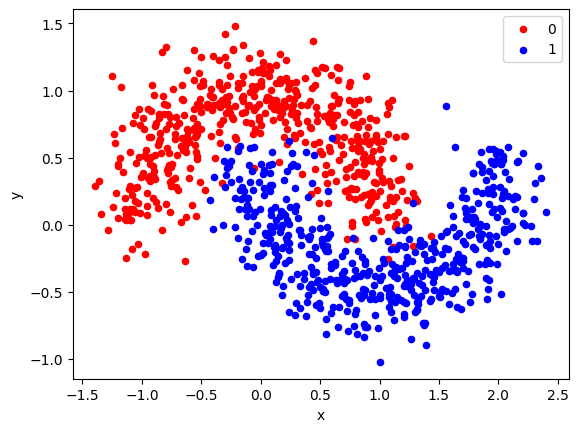

In [ ]:
import matplotlib.pyplot as plt

df = DataFrame(dict(x=X[:,0], y = X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
  group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.show()

In [ ]:
hist = nn.train(X_train.T, y_train.reshape(1, y_train.shape[0]), 1000, 0.1)

Iteration: 00000 - cost: 0.69509 - accuracy: 0.49556
Iteration: 00050 - cost: 0.69228 - accuracy: 0.49667
Iteration: 00100 - cost: 0.69102 - accuracy: 0.50444
Iteration: 00150 - cost: 0.68836 - accuracy: 0.67556
Iteration: 00200 - cost: 0.68028 - accuracy: 0.82444
Iteration: 00250 - cost: 0.64183 - accuracy: 0.84000
Iteration: 00300 - cost: 0.43950 - accuracy: 0.85444
Iteration: 00350 - cost: 0.29377 - accuracy: 0.87667
Iteration: 00400 - cost: 0.28068 - accuracy: 0.87778
Iteration: 00450 - cost: 0.27648 - accuracy: 0.88000
Iteration: 00500 - cost: 0.27201 - accuracy: 0.88111
Iteration: 00550 - cost: 0.26648 - accuracy: 0.88000
Iteration: 00600 - cost: 0.25979 - accuracy: 0.88000
Iteration: 00650 - cost: 0.25365 - accuracy: 0.88333
Iteration: 00700 - cost: 0.24837 - accuracy: 0.88556
Iteration: 00750 - cost: 0.24416 - accuracy: 0.88667
Iteration: 00800 - cost: 0.23042 - accuracy: 0.89222
Iteration: 00850 - cost: 0.21399 - accuracy: 0.90000
Iteration: 00900 - cost: 0.18444 - accuracy: 0

In [ ]:
pred, _ = nn.predict(X_test.T)

In [ ]:
accuracy_score(y_test, pred)

0.98

In [ ]:
hist

([array(0.69508513),
  array(0.69495218),
  array(0.69482371),
  array(0.69469928),
  array(0.69457828),
  array(0.69446194),
  array(0.69435024),
  array(0.694244),
  array(0.69414352),
  array(0.69404844),
  array(0.69395841),
  array(0.69387309),
  array(0.69379217),
  array(0.69371536),
  array(0.6936424),
  array(0.69357303),
  array(0.69350703),
  array(0.69344419),
  array(0.69338434),
  array(0.69332726),
  array(0.69327282),
  array(0.6932208),
  array(0.69317106),
  array(0.69312343),
  array(0.69307777),
  array(0.69303396),
  array(0.69299188),
  array(0.69295141),
  array(0.69291248),
  array(0.69287496),
  array(0.69283876),
  array(0.69280378),
  array(0.69276994),
  array(0.69273716),
  array(0.69270537),
  array(0.6926745),
  array(0.69264446),
  array(0.69261521),
  array(0.69258669),
  array(0.69255886),
  array(0.69253165),
  array(0.69250497),
  array(0.69247879),
  array(0.69245308),
  array(0.69242782),
  array(0.69240297),
  array(0.69237847),
  array(0.69235434

## Implemantare folosind tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

In [ ]:
model = Sequential([
    Input(shape=(2,)),
    Dense(25, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 25)                  │              75 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,226 (20.41 KB)

 Trainable params: 5,226 (20.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(epochs=1000, x=X_train, y=y_train, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.4793 - loss: 0.6911 - val_accuracy: 0.4900 - val_loss: 0.6912
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5054 - loss: 0.6891 - val_accuracy: 0.5500 - val_loss: 0.6895
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6071 - loss: 0.6865 - val_accuracy: 0.6100 - val_loss: 0.6879
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6778 - loss: 0.6850 - val_accuracy: 0.6200 - val_loss: 0.6865
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7224 - loss: 0.6832 - val_accuracy: 0.6600 - val_loss: 0.6852
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7530 - loss: 0.6815 - val_accuracy: 0.7000 - val_loss: 0.6839
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7567 - loss: 0.6799 - val_accuracy: 0.7000 - val_loss: 0.6827
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7656 - loss: 0.6789 - val_accuracy: 0.7000 - 

In [ ]:
model.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9908 - loss: 0.0672 


[0.07133176177740097, 0.9900000095367432]